In [ ]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# find device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print("Using {} device".format(device))

In [ ]:
class processDataset():
    def __init__(self, datasetPath, resize_size):
        # Data augmentation and normalisation
        transform = transforms.Compose([
            transforms.Resize((resize_size, resize_size)),                      # Resizing for VGG input
            transforms.ToTensor(),                                              # Convert to tensor
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisation
        ])
        
        # Use ImageFolder to load your dataset:
        self.fullDataset = datasets.ImageFolder(root=datasetPath, transform=transform)        

        # Extract labels
        labels = [label for _, label in self.fullDataset]

        # Perform stratified split
        train_indices, val_indices = train_test_split(
            range(len(self.fullDataset)), test_size=0.2, stratify=labels, random_state=42
        )

        # Create subsets
        train_dataset = torch.utils.data.Subset(self.fullDataset, train_indices)
        val_dataset = torch.utils.data.Subset(self.fullDataset, val_indices)            

        # Compute class weights using scikit-learn
        train_labels = [self.fullDataset[idx][1] for idx in train_indices]
        self.class_weights = compute_class_weight(
            class_weight="balanced",
            classes=np.unique(train_labels),
            y=train_labels
        )
        
        self.class_weights = torch.tensor(self.class_weights, dtype=torch.float32).to(device)
        print("Class weights:", self.class_weights)        

        self.train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
        self.val_loader = DataLoader(val_dataset, batch_size=10, shuffle=False, num_workers=2) 

datasetPath = r"C:\Users\sugie\OneDrive - The University of Nottingham\2024-2025\Actual Modules\EEEE4008 - Dissertation\Code\Visual-Geometry-Group\subSystemTesting\processDataset\testingImages"
dataset = processDataset(datasetPath, 224)   

Class weights: tensor([1.5000, 0.7500], device='cuda:0')


### Unit testing:

In [ ]:
# a) Loading images test
print("Total images in dataset:", len(dataset.fullDataset))
print("Sample image shape:", dataset.fullDataset[0][0].shape)  # Should match [3, 224, 224]
# Expected output:
# Total images in dataset: [Number of images]
# Sample image shape: torch.Size([3, 224, 224])

# b) Stratified split test
train_labels = [dataset.fullDataset[idx][1] for idx in dataset.train_loader.dataset.indices]
val_labels = [dataset.fullDataset[idx][1] for idx in dataset.val_loader.dataset.indices]

print("Train label distribution:", Counter(train_labels))
print("Validation label distribution:", Counter(val_labels))
# Expected Output: {1: 16, 0: 8}, {1: 4, 0: 2}

# c) Class weights computation test
print("Computed class weights:", dataset.class_weights)
# Expected Output: [1.5000, 0.7500]

Total images in dataset: 30
Sample image shape: torch.Size([3, 224, 224])
Train label distribution: Counter({1: 16, 0: 8})
Validation label distribution: Counter({1: 4, 0: 2})
Computed class weights: tensor([1.5000, 0.7500], device='cuda:0')


### Visual Testing:

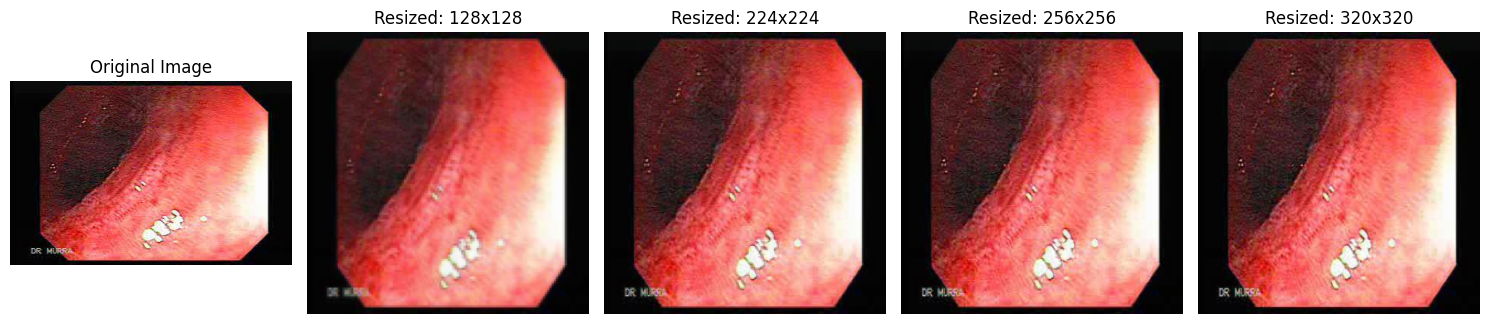

In [ ]:
# display image function
def imshow(img, title, ax):
    img = img.numpy().transpose((1, 2, 0))  # Convert tensor to numpy format
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalise
    img = np.clip(img, 0, 1)  # Ensure valid pixel values
    ax.imshow(img)
    ax.set_title(title, fontsize=12)
    ax.axis("off")  # Hide axes

# list of resize values
resize_values = [128, 224, 256, 320]

# Load the same image before transformation
originalImgPath, _ = dataset.fullDataset.imgs[19]  # Get sample image
originalImg = Image.open(originalImgPath) 

# Create a figure with subplots for different sizes
fig, axes = plt.subplots(1, len(resize_values) + 1, figsize=(15, 5))

# Show the original image (before transformation)
axes[0].imshow(originalImg)
axes[0].set_title("Original Image", fontsize=12)
axes[0].axis("off")

# apply transformation for different resize values
for i, resize_size in enumerate(resize_values):
    transform = transforms.Compose([
        transforms.Resize((resize_size, resize_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalisation
    ])
    
    transformedImg = transform(originalImg)  # Apply transformation
    
    imshow(transformedImg, f"Resized: {resize_size}x{resize_size}", axes[i + 1])

plt.tight_layout()
plt.show()

### Integration Testing:

In [ ]:
# Load VGG11 model
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=False)

num_classes = 2
model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
model.to(device)

# Test with batch from the dataset
sample_batch = next(iter(dataset.train_loader))
images, labels = sample_batch

outputs = model(images.to(device))

print("Output shape:", outputs.shape)
# Expected output: Output shape: torch.Size([10, 2])